## 13.6. 目标检测数据集

### 13.6.1. 下载数据集

In [1]:
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

In [3]:
d2l.DATA_HUB['banana-detection'] = (d2l.DATA_URL + 'banana-detection.zip', '5de26c8fce5ccdea9f91267273464dc968d20d72')

### 13.6.2. 读取数据集

In [6]:
data_dir = d2l.download_extract('banana-detection')

In [7]:
data_dir

'../data\\banana-detection'

In [24]:
#@save
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():  
        # img_name: num.png,  
        # target: type为Series， 
        # 值举例   label      0
        #         xmin     183
        #         ymin      63
        #         xmax     241
        #         ymax     112
        #         Name: 0.png, dtype: int64
        
        images.append(
            # shape: [3, 256, 256]
            torchvision.io.read_image(os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'images', f'{img_name}'))
        )
        
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    # images: list, element_shape: [3, 256, 256]
    # torch.tensor(targets).unsqueeze(1)/256: shape, [100 or 1000, 1, 5]
    return images, torch.tensor(targets).unsqueeze(1) / 256 

In [40]:
#@save
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [49]:
#@save
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True ), batch_size, shuffle=True)
    val_iter   = torch.utils.data.DataLoader(BananasDataset(is_train=False), batch_size)
    return train_iter, val_iter

In [50]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

### 13.6.3. 演示

In [71]:
batch[0][0:10].permute(0, 2, 3, 1).shape

torch.Size([10, 256, 256, 3])

In [75]:
batch[1][0:10]

tensor([[[0.0000, 0.1953, 0.0469, 0.4336, 0.2578]],

        [[0.0000, 0.4180, 0.4688, 0.6523, 0.7031]],

        [[0.0000, 0.6211, 0.0547, 0.8281, 0.2539]],

        [[0.0000, 0.5039, 0.5273, 0.7852, 0.7461]],

        [[0.0000, 0.0508, 0.1836, 0.2617, 0.3828]],

        [[0.0000, 0.2773, 0.3438, 0.4883, 0.6055]],

        [[0.0000, 0.3555, 0.1211, 0.5625, 0.3203]],

        [[0.0000, 0.5195, 0.5000, 0.7070, 0.6758]],

        [[0.0000, 0.1719, 0.2070, 0.3164, 0.4062]],

        [[0.0000, 0.3398, 0.0430, 0.6016, 0.2695]]])

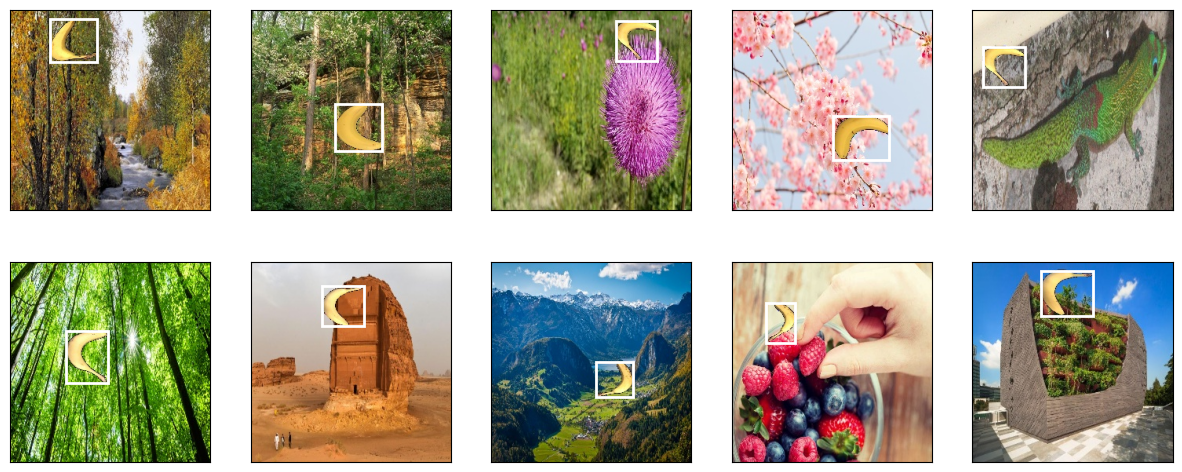

In [85]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=3)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])